In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_46/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>


<a id="section_TOC"></a> 

## Tabla de Contenidos

[1- Introducción](#section_intro)

$\hspace{.5cm}$[1.1- El problema de la dimensionalidad](#section_dimension)

$\hspace{.5cm}$[1.2- Bag of words](#section_bag_of_words)

[2- Preprocesamiento de texto](#section_NLTK)

$\hspace{.5cm}$[2.1 Tokenización](#section_token)

$\hspace{.5cm}$[2.2 Generación de vocabulario](#section_vocabulary)

$\hspace{1cm}$[2.2.1 Stopwords](#section_stopwords)

$\hspace{1cm}$[2.2.2 Stemming and Lemmatization](#section_stem_lemma)

$\hspace{.5cm}$[2.3 Ejemplo](#section_caso)

$\hspace{.5cm}$[2.4 Encoding: vectorización de los documentos](#section_encoding)

[3- Singular value decomposition](#section_SVD)

[4- La biblioteca de Babel](#section_babel)





<a id="section_intro"></a> 

### Introducción
[Volver al índice](#section_TOC)

En esta práctica trabajaremos con datos de tipo texto. Algo hemos hecho ya cuando preprocesamos datasets usando, por ejemplo, expresiones regulares. Lo que hacíamos en ese entonces era buscar algo que ya sabíamos que estaba allí. La tarea que nos ocupará ahora es diferente. Queremos usar los algoritmos de machine learning que estuvimos aprendiendo para hacer, por ejemplo, clasificación, pero con textos.

Existen múltiples escenarios en los cuales querríamos hacer esto. Uno de los primeros problemas de aplicación de machine learning, de hecho, fue el de clasificación de correos como spam o no-spam. Otros casos son la clasificación de comentarios de usuarios sobre algún producto como positivos o negativos, identificar a qué sección de un diario pertenecen distintas notas, etc. En definiva, queremos extraer información sobre el contenido de los textos.

Para poder implementar los modelos que ya conocemos, necesitamos representar los datos como una matriz de features. En el caso de modelos de aprendizaje supervisado, necesitamos además una etiqueta, como spam/ham.

<b>¿Cómo convertirían un texto en una matriz de features?</b>

<a id="section_dimension"></a> 
### El problema de la dimensionalidad
[Volver al índice](#section_TOC)

Los textos son secuencias de palabras (y signos de puntuación!) y el sentido de los mismos está contenido precisamente en las estructuras semánticas que forman estos elementos combinados. Es decir que el sentido no está dado por la mera presencia de las palabras, sino por cómo se articulan.

En 'La Biblioteca de Babel', Borges imagina una biblioteca compuesta por libros de tamaño fijo que contienen todas las combinaciones posibles de los 22 caracteres de un alfabeto, más el punto, la coma y el espacio. En el cuento, los libros son de 410 páginas, cada una con 40 renglones de 80 caracteres cada uno. 

El número de libros distintos que se pueden formar de esta manera es abismal (¿cómo lo calcularían?). Dado que los libros de la biblioteca contienen todas las combinaciones de caracteres posibles, algunos de estos libros son casi iguales: tal es el caso de aquellos que difieren sólo en un puñado de caracteres. Considerar a tales libros como diferentes sería un despropósito si lo que importa es el sentido semántico de los textos. Por otro lado, la mayoría de los libros en la biblioteca es, presumiblemente, una secuencia de caracteres sin sentido, no interpretables en ningún idioma. En la historia, sin embargo, los sujetos que habitan la biblioteca (los bibliotecarios), la recorren incansablemente en busca del libro que contenga su destino, o el de la humanidad, o aquél que sea el catálogo de la biblioteca. 

¿Cómo cambiaría la tarea de los bibliotecarios, si contaran con herramientas de machine learning para ordenar la biblioteca? 

Dejando de lado el hecho de que arruinarían el bello cuento de Borges, veamos cómo podrían implementar algunas herramientas de procesamiento de texto para dicha tarea.

Podríamos empezar por no considerar *cualquier* combinación de caracteres sino solamente aquellas que forman palabras dentro de un vocabulario. El número de textos posibles se reduciría enormemente, pero seguiría siendo muy grande. Esto es importante porque la tarea de organizar la biblioteca implica comparar textos, ver cuáles son más parecidos entre sí que respecto a otros. Esto es, buscar una estructura en el *espacio de los textos posibles*. El problema es que de acuerdo a lo discutido más arriba, ese espacio es de una dimensionalidad enorme. Para poder computar métricas de distancia entre los textos, para poder entrenar algoritmos de machine learning que nos permitan encontrar patrones en los datos, necesitamos definir representaciones reducidas de los textos.


<a id="section_bag_of_words"></a> 
### Bag of words
[Volver al índice](#section_TOC)

Una de las maneras más simples y efectivas de representar los textos es la que se conoce como "bag of words" y consiste en descartar la mayor parte de la estructura de los textos como párrafos, capítulos, etc, y conservar únicamente el conjunto de palabras y el número de veces que aparecen en el texto. Es decir, olvidamos el orden en que aparecen. Matemáticamente, el número de maneras en que podemos ordenar n elementos se calcula como n! (se lee 'factorial de n' o 'n factorial') y vale:

$n!=n*(n-1)*(n-2)*(n-3)*...*3*2*1$

Es decir que si tuviéramos 10 palabras diferentes para construir un texto (una oración), podríamos construir $3628800$ textos distintos ya que

$10!=10*9*8*7*6*5*4*3*2*1 = 3628800 $ 

Pero en el esquema "bag of words" todos ellos estarían representados de la misma manera (la misma bolsa de palabras), de manera que serían textos indistinguibles (y el bibliotecario de babel los ubicaría en la misma sección).

Antes de seguir desambigüemos un poco la jerga. Llamaremos **corpus** a un conjunto de textos (por ejemplo la biblioteca de Babel) y **documento** a cada texto que compone el corpus (puede ser un libro, un twit o el comentario de un usuario) y que a la vez es nuestra unidad de dato (sería una fila en un dataframe).

Computar la representación "bag of words" de un corpus de documentos conlleva tres pasos:

1. Tokenización: convertir cada documento a una lista de palabras (y signos de puntuación) que lo componen.
2. Construcción de un vocabulario: colectar todas las palabras que se registraron en el corpus y ordenarlas (típicamente por orden alfabético).
3. Encoding: representar los documentos como vectores en el espacio de las palabras del vocabulario.

Veremos cada uno de estos pasos en detalle y luego incorporaremos herramientas de sklearn que permiten aglutinar todo en un sólo modelo.





<a id="section_NLTK"></a>
### Preprocesamiento de texto
[Volver al índice](#section_TOC)


https://www.nltk.org

NLTK (Natural Language Toolkit) es una librería de python de código abierto para el procesamiento de lenguaje natural. Tiene un libro online gratuito para consultar:

Steven Bird, Ewan Klein, and Edward Loper (2009). Natural Language Processing with Python. O’Reilly Media Inc. http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf





In [2]:
# ! conda install --yes nltk==3.4.5
# ! conda install --yes unidecode

In [3]:
import nltk

<a id="section_token"></a>

### Tokenización
[Volver al índice](#section_TOC)


Tokenización es la transformación de un texto a unidades constitutivas llamadas tokens. Los tokens son típicamente las palabras y signos de puntuación. Podríamos intentar hacer esto mediante métodos de la clase string que ya conocemos, por ejemplo usando split(' ') para partir el string en los espacios en blanco.



In [4]:
sentence="Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success."
print(sentence,'\n')
print(sentence.split(' '))

Pythoners are very intelligent and work very pythonly and now they are pythoning their way to success. 

['Pythoners', 'are', 'very', 'intelligent', 'and', 'work', 'very', 'pythonly', 'and', 'now', 'they', 'are', 'pythoning', 'their', 'way', 'to', 'success.']


#### Tokenizers

Como vemos esto tiene el problema de que no separa las palabras de los signos de puntuación, como se nota en el último token: "success."

La librería NLTK cuenta con herramientas un poco más sofisticadas para hacer esto, identificando los signos de puntuación y cuándo los mismos separan oraciones y cuándo cumplen otra función, como una abreviatura.

In [5]:
from nltk.tokenize import word_tokenize, sent_tokenize
print(word_tokenize(sentence))

['Pythoners', 'are', 'very', 'intelligent', 'and', 'work', 'very', 'pythonly', 'and', 'now', 'they', 'are', 'pythoning', 'their', 'way', 'to', 'success', '.']


 Por otro lado, si quisiéramos obtener una lista de oraciones usando split obtendríamos problemas similares:

In [6]:
text = "This is the first sentence. A gallon of milk in the U.S. costs $2.99. Is this the third sentence? Yes, it is!"
print('Oración original:')
print(text,'\n')


sentences=text.split('.')

print('Tokenizamos usando split:')
print(sentences,'\n')

print('Tokenizamos usando sent_tokenize:')
print(sent_tokenize(text))



Oración original:
This is the first sentence. A gallon of milk in the U.S. costs $2.99. Is this the third sentence? Yes, it is! 

Tokenizamos usando split:
['This is the first sentence', ' A gallon of milk in the U', 'S', ' costs $2', '99', ' Is this the third sentence? Yes, it is!'] 

Tokenizamos usando sent_tokenize:
['This is the first sentence.', 'A gallon of milk in the U.S. costs $2.99.', 'Is this the third sentence?', 'Yes, it is!']


Es posible que en algunos casos el tokenizador falle, por ejemplo no reconociendo una abreviatura. En el siguiente ejemplo el tokenizador no reconoce 'al.' de modo que interpreta el punto como el fin de una oración.




In [7]:
# EJEMPLO EN DONDE FALLA sent_tokenizer
text2="According to Hotho et al. (2005) we can differ three different perspectives of text mining, namely text mining as information extraction, text mining as text data mining, and text mining as KDD (Knowledge Discovery in Databases) process. Text mining is 'the discovery by computer of new, previously unknown information, by automatically extracting information from different written resources."
tokenized_2=sent_tokenize(text2);
tokenized_2

['According to Hotho et al.',
 '(2005) we can differ three different perspectives of text mining, namely text mining as information extraction, text mining as text data mining, and text mining as KDD (Knowledge Discovery in Databases) process.',
 "Text mining is 'the discovery by computer of new, previously unknown information, by automatically extracting information from different written resources."]

Podemos *tunear* el tokenizador incluyendo abreviaturas *a piacere*. Para ello, en lugar de importar la función sent_tokenize, instanciamos los objetos PunkTrainer y PunktSentenceTokenizer. La idea de la siguiente celda no es explicar en detalle estos objetos, sino mostrarles que existen y referirlos [aquí](https://nlpforhackers.io/splitting-text-into-sentences/) para más información.

(Si la url anterior no está accesible pueden consultar http://www.nltk.org/api/nltk.tokenize.html?highlight=tokenizer#nltk.tokenize.punkt.PunktTrainer)

In [8]:
#nltk.download('punkt')
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
tokenizer = PunktSentenceTokenizer(trainer.get_params())
tokenizer._params.abbrev_types.add('al')
tokenized_text2=tokenizer.tokenize(text2);
tokenized_text2

['According to Hotho et al. (2005) we can differ three different perspectives of text mining, namely text mining as information extraction, text mining as text data mining, and text mining as KDD (Knowledge Discovery in Databases) process.',
 "Text mining is 'the discovery by computer of new, previously unknown information, by automatically extracting information from different written resources."]

<a id="section_vocabulary"></a> 

### Generación del vocabulario
[Volver al índice](#section_TOC)


Dijimos que vamos a representar los textos como una bolsa de palabras. Es decir que podríamos tokenizar todos los documentos y definir el vocabulario como el set de palabras que aparecieron al menos una vez en todo el corpus.
Esto tiene el problema de que el número de palabras será muy grande y muchas de ellas serán muy poco informativas sobre el contenido del texto, por ejemplo las preposiciones, pronombres, etc. A estas palabras se las llama stopwords y a menudo se las excluye del vocabulario. Además, otra técnica para reducir la dimensionalidad del problema consiste en agrupar palabras que comparten la misma raíz etimológica como "correr", "corriendo", "corredor".

<a id="section_stopwords"></a> 

#### Stopwords
[Volver al índice](#section_TOC)

NLTK tiene listas de stopwords en distintos idiomas, podemos acceder a las mismas del siguiente modo:

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords 
stopwords_sp = stopwords.words('spanish');

print('\n Las primeras 20 en español:')
print(stopwords_sp[:20])

stopwords_en=stopwords.words('english');

print('\n Las primeras 20 en ingles:')
print(stopwords_en[:20])



 Las primeras 20 en español:
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo']

 Las primeras 20 en ingles:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/csuarezgurruchaga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="section_stem_lemma"></a> 

#### Stemming y Lemmatization 
[Volver al índice](#section_TOC)


Stemming y lemmatization son maneras de reducir las palabras a su raíz etimológica. En el caso de stemming, esto se hace por sustracción de sufijos y prefijos de las palabras. La raíz que queda (stem) muchas veces no es una palabra en sí misma. Por ejemplo al pasar la palabra "corriendo" por un stemmer obtenemos "corr". 

El lematizador, por el contrario, siempre devuelve una versión reducida de la palabra (lema), pero que es en sí misma una palabra de la misma familia.

Para profundizar:
https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

#### Stemming

Para el idioma inglés, podemos elegir entre PorterStammer o LancasterStammer, siendo PorterStemmer el más antiguo desarrollado originalmente en 1979. LancasterStemmer se desarrolló en 1990 y utiliza un enfoque más agresivo que el algoritmo de stemming de Porter. 



In [10]:
# Importamos los algoritmos de Stemming

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [11]:
# Creamos objects a partir de las clases PorterStemmer y LancasterStemmer

porter = PorterStemmer()
lancaster=LancasterStemmer()


# Le pasamos palabras a ambos algoritmos para que hagan stemming:
print("Porter Stemmer")
print(porter.stem("cats"))
print(porter.stem("trouble"))
print(porter.stem("troubling"))
print(porter.stem("troubled"))
print("\n")
print("Lancaster Stemmer")
print(lancaster.stem("cats"))
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))
print("\n")

# Creamos una lista de palabras para hacer stemming con ambos algoritmos:
word_list = ["friend", "friendship", "friends", "friendships","stabil","destabilize","misunderstanding","railroad","moonlight","football"]
print("{0:20}{1:20}{2:20}".format("Word","Porter Stemmer","lancaster Stemmer"))
for word in word_list:
    print("{0:20}{1:20}{2:20}".format(word,porter.stem(word),lancaster.stem(word)))



Porter Stemmer
cat
troubl
troubl
troubl


Lancaster Stemmer
cat
troubl
troubl
troubl


Word                Porter Stemmer      lancaster Stemmer   
friend              friend              friend              
friendship          friendship          friend              
friends             friend              friend              
friendships         friendship          friend              
stabil              stabil              stabl               
destabilize         destabil            dest                
misunderstanding    misunderstand       misunderstand       
railroad            railroad            railroad            
moonlight           moonlight           moonlight           
football            footbal             footbal             


#### Stemmers en otros idiomas:

Python **nltk** no solo proporciona dos stemmers en inglés: PorterStemmer y LancasterStemmer, sino también muchos stemmers que no están en inglés como **SnowballStemmers**.

Idiomas que maneja **SnowballStemmers**:

 - danés
 - holandés
 - inglés
 - francés
 - alemán
 - húngaro
 - italiano
 - noruego
 - portugués
 - rumano
 - ruso
 - español
 - sueco

In [12]:
from nltk.stem.snowball import SnowballStemmer
word='having';
englishStemmer=SnowballStemmer("english")
print("{0:15}{1:10}".format(word, englishStemmer.stem(word)))

palabra='corriendo';
spanishStemmer=SnowballStemmer("spanish")
print("{0:15}{1:10}".format(palabra, spanishStemmer.stem(palabra)))

having         have      
corriendo      corr      


In [13]:
# Defimimos una función que aplica stemming a una frase en castellano:
def stemfraseesp(frase):    
    token_words=word_tokenize(frase)
    token_words
    stem_sentence=[]    
    spanishStemmer=SnowballStemmer("spanish",ignore_stopwords=True)
    for word in token_words:
        stem_sentence.append(spanishStemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


In [14]:
frase1 = "Una frase de prueba en castellano para aplicar stemming"

x=stemfraseesp(frase1)
print(x)

una fras de prueb en castellan para aplic stemming 


#### Lemmatization en NLTK

In [15]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
import re # Libreria para editar texto mediante expresiones regulares

wordnet_lemmatizer = WordNetLemmatizer()

sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
sentence=re.sub(r'[.]','',sentence) ; # Removemos los puntos antes de tokenizar. Usamos una expresión regular que reemplaza los '.' por un string vacio ''

sentence_words = word_tokenize(sentence);
print("\n{0:20}{1:20}{2:20}\n".format("Word","Lemma",'Stem'))
for word in sentence_words:
    print ("{0:20}{1:20}{2:20}".format(word,wordnet_lemmatizer.lemmatize(word),englishStemmer.stem(word)))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/csuarezgurruchaga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Word                Lemma               Stem                

He                  He                  he                  
was                 wa                  was                 
running             running             run                 
and                 and                 and                 
eating              eating              eat                 
at                  at                  at                  
same                same                same                
time                time                time                
He                  He                  he                  
has                 ha                  has                 
bad                 bad                 bad                 
habit               habit               habit               
of                  of                  of                  
swimming            swimming            swim                
after               after               after               
playing             pl

<a id="section_caso"></a> 

#### Antes de seguir, apliquemos lo visto hasta aquí a un pequeño corpus

[Volver al índice](#section_TOC)


In [16]:
# Generamos textos 

t0 = "El potro y el angel llegaron al cine por casualidad."
t1 = "El ángel, el tanque del cine nacional, un paso más cerca del oscar"
t2 = "final del mes del cine nacional: 'El Potro', la única cinta 'millonaria'"
t3 = "Juan Martin del potro volvió a tandil: se dio el ultimo baño de masas con los suyos."
t4 = "Juan Martin del potro fue recibido por una multitud en Tandil."
t5=  "Juan Martin del potro fue a ver 'El Potro' al cine y le encantó."
textos=[t0,t1,t2,t3,t4,t5];

#### Vamos a remover signos de puntuación, llevar todo el texto a minúsculas e ignorar las tildes.

In [17]:
import unidecode
import re

textos_limpios=[];
for t in textos:
    t_lower_no_accents=unidecode.unidecode(t.lower()); # sacamos acentos y llevamos a minuscula
    t_lower_no_accents_no_punkt=re.sub(r'([^\s\w]|_)+','',t_lower_no_accents); # quitamos signos de puntuacion usando una regex que reemplaza todo lo q no sean espacios o palabras por un string vacio
    print(t_lower_no_accents_no_punkt)
    textos_limpios.append(t_lower_no_accents_no_punkt)
    

el potro y el angel llegaron al cine por casualidad
el angel el tanque del cine nacional un paso mas cerca del oscar
final del mes del cine nacional el potro la unica cinta millonaria
juan martin del potro volvio a tandil se dio el ultimo bano de masas con los suyos
juan martin del potro fue recibido por una multitud en tandil
juan martin del potro fue a ver el potro al cine y le encanto


#### Tokenizamos y removemos stopwords

In [18]:
# Tokenizamos los textos, removiendo stopwords
tokenized_texts=[];
for t in textos_limpios:
    tokens=word_tokenize(t);
    tokens_without_stopwords=[tok for tok in tokens if not (tok in stopwords_sp)]; # Creamos una lista de tokens que no pertenecen a la lista de stopwords
    print(tokens_without_stopwords)
    tokenized_texts.append(tokens_without_stopwords);

['potro', 'angel', 'llegaron', 'cine', 'casualidad']
['angel', 'tanque', 'cine', 'nacional', 'paso', 'mas', 'cerca', 'oscar']
['final', 'mes', 'cine', 'nacional', 'potro', 'unica', 'cinta', 'millonaria']
['juan', 'martin', 'potro', 'volvio', 'tandil', 'dio', 'ultimo', 'bano', 'masas']
['juan', 'martin', 'potro', 'recibido', 'multitud', 'tandil']
['juan', 'martin', 'potro', 'ver', 'potro', 'cine', 'encanto']


In [19]:
# Construimos el vocabulario como el set de tokens conservados
vocabulary=sorted(set([tok for tokens in tokenized_texts for tok in tokens]));
print(vocabulary)

['angel', 'bano', 'casualidad', 'cerca', 'cine', 'cinta', 'dio', 'encanto', 'final', 'juan', 'llegaron', 'martin', 'mas', 'masas', 'mes', 'millonaria', 'multitud', 'nacional', 'oscar', 'paso', 'potro', 'recibido', 'tandil', 'tanque', 'ultimo', 'unica', 'ver', 'volvio']


<a id="section_encoding"></a>

### Encoding: representación vectorial de los documentos
[Volver al índice](#section_TOC)

De acuerdo a lo discutido en la introducción, en el esquema "Bag of words" podemos representar a los documentos en función de qué palabras los componen, sin considerar las estructuras semánticas que éstas forman. De esta manera, un documento puede representarse como un vector en el espacio de palabras que conforman el vocabulario. Existen diferentes maneras de definir estos vectores. La más intuitiva es contar el número de veces que aparece cada palabra en un documento y asignarlo como la coordenada o el peso correspondiente a dicha palabra en el vector. Veamoslo en un ejemplo.



In [20]:
import numpy as np
import pandas as pd

Encoded_data=np.zeros((len(tokenized_texts),len(vocabulary)),dtype='int')
for i,text in enumerate(tokenized_texts):
    for word in text:
        Encoded_data[i,vocabulary.index(word)]+=1 # contamos
Encoded_data=pd.DataFrame(Encoded_data,columns=vocabulary,index=['t'+str(i) for i in range(len(tokenized_texts))]);
Encoded_data


,angel,bano,casualidad,cerca,cine,cinta,dio,encanto,final,juan,...,oscar,paso,potro,recibido,tandil,tanque,ultimo,unica,ver,volvio
t0,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
t1,1,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
t2,0,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
t3,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,1,0,1,0,0,1
t4,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,1,0,0,0,0,0
t5,0,0,0,0,1,0,0,1,0,1,...,0,0,2,0,0,0,0,0,1,0


#### CountVectorizer

Todo lo anterior lo podemos hacer en un sólo paso con la herramienta CountVectorizer de scikit-learn. 


Notar que al momento de instanciarla, nos permite pasarle una lista de stopwords para que no las tenga en cuenta.
Como todos los modelos de sklearn, tiene los métodos fit y transform. En este caso "fit" genera el vocabulario a partir de los documentos, y "transform" vectoriza los documentos al espacio del vocabulario.

Como típicamente el vocabulario es muy grande, las matrices son muy esparsas (tienen muchos ceros) por lo que es conveniente almacenar sólamente las entradas no nulas de las mismas en un objeto de la clase "sparse matrix". CountVectorizer genera matrices de esta clase.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# The solution is to make sure that you preprocess your stop list to make sure that it is normalised like your tokens will be, 
# and pass the list of normalised words as stop_words to the vectoriser.
# vectorizer=CountVectorizer(stop_words=stopwords_sp,lowercase=True,strip_accents='unicode');

# si no hacemos esto y usamos directo stopwords_sp, CountVectorizer devuelve un warning
stopwords_sp_stem = [spanishStemmer.stem(x) for x in stopwords_sp]

vectorizer=CountVectorizer(stop_words=stopwords_sp_stem,lowercase=True,strip_accents='unicode');

vectorizer.fit(textos);
print('Vocabulario:\n',vectorizer.vocabulary_) # vocabulario del corpus con la frecuencia de cada término


CV_encoding=vectorizer.transform(textos);
print('\n Transformamos los textos a una matriz esparsa:',type(CV_encoding))

pd.DataFrame(CV_encoding.todense(),columns=vectorizer.get_feature_names()) # Usamos el método .todense() para ver la matriz completa



Vocabulario:
 {'potro': 19, 'angel': 0, 'llegaron': 10, 'cine': 4, 'casualidad': 2, 'tanque': 23, 'nacional': 16, 'paso': 18, 'cerca': 3, 'oscar': 17, 'final': 8, 'mes': 13, 'unica': 25, 'cinta': 5, 'millonaria': 14, 'juan': 9, 'martin': 11, 'volvio': 27, 'tandil': 22, 'dio': 6, 'ultimo': 24, 'bano': 1, 'masas': 12, 'suyos': 21, 'recibido': 20, 'multitud': 15, 'ver': 26, 'encanto': 7}

 Transformamos los textos a una matriz esparsa: <class 'scipy.sparse.csr.csr_matrix'>


,angel,bano,casualidad,cerca,cine,cinta,dio,encanto,final,juan,...,paso,potro,recibido,suyos,tandil,tanque,ultimo,unica,ver,volvio
0,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,1,0,0,1,...,0,1,0,1,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,1,0,1,...,0,2,0,0,0,0,0,0,1,0


#### Term Frequency Inverse Document Frequency (TF-IDF)

La representación de los textos generada mediante countvectorizer tiene en cuenta cuántas veces se observó cada término del vocabulario en cada documento. El corpus con el que trabajamos hasta ahora es extremadamente chico y homogéneo (6 textos de una oración cada uno), pero podría pasar que un documento fuera mucho más largo que los otros y por lo tanto el conteo de palabras diera números mucho mayores en él que en el resto de los documentos. Para corregir esta anomalía, deberíamos normalizar (dividir) el conteo de cada palabra por el tamaño de cada documento.

Pero además de hacer esto, hay palabras que aparecen en muchos documentos y resultan entonces poco informativas para distinguirlos. Una palabra que aparece muchas veces en un documento, pero pocas veces en los demás, es una palabra muy distintiva de ese documento y será importante para representarlo, mientras que palabras que aparecen pocas veces, o que aparecen en muchos documentos serán menos informativas. 

La transformación TF-IDF tiene en cuenta estos factores de la siguiente manera. El término 't' dentro del documento 'd' tiene un coeficiente tf-idf(t,d) que es el producto de dos factores:

\begin{equation}
 \text{tf-idf}(t,d)=\text{tf}(t,d) \times idf(t)
\end{equation}

Por un lado tf(t,d) es la frecuencia de aparición de t dentro de d (normalizada). Por otro lado, idf(t) es la inverse document frecuency del término t y se calcula como:
\begin{equation}
    \text{idf}(t)=\log{\frac{N}{\text{df(t)+1}}} 
\end{equation}

en donde N es el número de documentos y df(t) es el número de documentos en los que aparece el término t. Se suele sumar 1 en el denominador para no tener problemas si existe un término en el vocabulario que no aparece en ningún documento (df=0). 


Por ejemplo:

document1='el potro y el angel llegaron al cine por casualidad'

document2='el angel el tanque del cine nacional un paso mas cerca del oscar'

document3='final del mes del cine nacional el angel la unica cinta millonaria'

document4='juan martin del potro volvio a tandil se dio el ultimo bano de masas con los suyos'


\begin{align}
    &\text{tf('nacional', document1)}=\frac{1}{10}=0.1\\
    &\text{tf('nacional', document2)}=\frac{1}{13}=0.077\\
    &\text{tf('nacional', document3)}=\frac{0}{12}=0\\
    &\text{tf('nacional', document4)}=\frac{0}{17}=0 \\
    &\text{idf('nacional')}=\log{\frac{4}{3}}=0.288
\end{align}

y los coeficientes tf-idf:

\begin{align}
    &\text{tf-idf('nacional',doc1)}=0.1\times 0.288=0.0288 \\
    &\text{tf-idf('nacional',doc2)}=0.077\times 0.288=0.0222 \\
    &\text{tf-idf('nacional',doc3)}=0\times 0.288=0 \\
    &\text{tf-idf('nacional',doc4)}=0\times 0.288=0
\end{align}

El coeficiente tfidf para "potro" en el documento 1 da:

\begin{equation}
    \text{tf-idf('potro',doc1)}= \frac{1}{10} \times \log{\frac{4}{2}}=0.07\\
\end{equation}

Podemos ver que si bien "potro" y "nacional" aparecen el mismo número de veces dentro del documento 1, "potro" tiene un coeficiente mayor porque no aparece en ningún otro documento. 

#### TfidfVectorizer, TfidfTransformer

En sklearn, los objetos de la clase TfidfTransformer sirven para transformar una matriz generada por CountVectorizer(). Podemos saltearnos el uso de countvectorizer y usar directamente TfidfVectorizer.

A diferencia de la estimación clásica del factor idf que vimos más arriba, TfidfVectorizer y TfidfTransformer por defecto calculan una versión suavizada del idf como

\begin{equation}
    \text{idf(t)}= \log{\frac{N+1}{df(t)+1}}+1
\end{equation}

y luego normaliza los documentos vectorizados por su norma L2. (ver https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)


In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

Tfidf_encoding=TfidfTransformer().fit_transform(CV_encoding);
pd.DataFrame(Tfidf_encoding.todense(),columns=vectorizer.get_feature_names())


,angel,bano,casualidad,cerca,cine,cinta,dio,encanto,final,juan,...,paso,potro,recibido,suyos,tandil,tanque,ultimo,unica,ver,volvio
0,0.452305,0.000000,0.551581,0.000000,0.327231,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.282590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.343563,0.000000,0.000000,0.418971,0.248559,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.418971,0.000000,0.000000,0.000000,0.000000,0.418971,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.236607,0.398826,0.000000,0.000000,0.398826,0.000000,...,0.000000,0.204329,0.000000,0.000000,0.000000,0.000000,0.000000,0.398826,0.000000,0.000000
3,0.000000,0.355931,0.000000,0.000000,0.000000,0.000000,0.355931,0.000000,0.000000,0.246415,...,0.000000,0.182353,0.000000,0.355931,0.291868,0.000000,0.355931,0.000000,0.000000,0.355931
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350859,...,0.000000,0.259643,0.506793,0.000000,0.415577,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.284104,0.000000,0.000000,0.478888,0.000000,0.331540,...,0.000000,0.490694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.478888,0.000000


<a id="section_SVD"></a>

### Singular Value Decomposition (SVD)

[Volver al índice](#section_TOC)

SVD es una manera de reducir la dimensionalidad del corpus de texto que, a diferencia de lo que hemos hecho hasta ahora, no consiste en remover elementos (stopwords, etc), sino en encontrar combinaciones de palabras que resulten informativas y quedarnos con "las mejores" de éstas. 

Una analogía posible es la siguiente: podemos describir un rectángulo dando dos variables (features): su base y su altura. Si quisiéramos describir el rectángulo con una sola de estas features, por ejemplo la base, estaríamos perdiendo información muy relevante ya que existen rectángulos muy diferentes con la misma base. Sin embargo, si generáramos una nueva variable "área" igual al producto de base por altura, y describiéramos al rectángulo usando solamente el área, estaríamos reduciendo la dimensionalidad de una manera mucho más razonable, guardando más información sobre el rectángulo original que al quedarnos solo con la base.

SVD es una transformación algebraica parecida a PCA (principal component analysis) que se puede usar en el contexto de text mining para encontrar combinaciones lineales de los términos que resulten informativas, de modo que podamos describir el data set con un número de combinaciones menor al número de términos que teníamos originalmente. De hecho, estas combinaciones pueden considerarse como dimensiones con *sentido semántico latente* (latent semantic dimensions), es decir, dimensiones en las que tiene sentido proyectar el dataset precisamente por su contenido semántico.

El motivo por el cual podemos reducir la dimensionalidad de los textos proyectandolos a estas *latent semantic dimensions* es que muchas veces existe redundancia en el conjunto de documentos. Es decir que con palabras más o menos distintas, muchos documentos hablan de los mismos temas. En el ejemplo de los 6 textos que venimos usando 


    t0='El potro y el angel llegaron al cine por casualidad.'
    t1= 'El ángel, el tanque del cine nacional, un paso más cerca del oscar',
    t2= "final del mes del cine nacional: 'El Potro', la única cinta 'millonaria'",
    t3= 'Juan Martin del potro volvió a tandil: se dio el ultimo baño de masas con los suyos.',
    t4= 'Juan Martin del potro fue recibido por una multitud en Tandil.',
    t5= "Juan Martin del potro fue a ver 'El Potro' al cine y le encantó."


hay 45 palabras distintas. (Antes redujimos el número de términos a 28 quitando stopwords). Sin embargo los textos hablan esencialmente de tres temas: hay dos películas nuevas en el cine, Del Potro visitó Tandil, Del Potro fue al cine. 

Esta reducción de la dimensionalidad podría mejorar la performance de un clasificador o un modelo de clustering. Por otro lado, una reducción a dos o tres dimensiones nos puede permitir visualizar los datos. Hay que tener en cuenta, sin embargo, que en general necesitaremos más dimensiones para describir correctamente el corpus y es posible que la representación en dos dimensiones no nos revele mucho sobre la estructura del dataset.

Lo anterior pretende dar una intuición sobre la descomposición SVD y su aplicación al análisis de textos. Comprender la matemática involucrada excede las ambiciones de esta presentación. Para indagar en ella pueden consultar alguna de estas referencias:

*Practical Text Mining and Statistical Analysis for Non-structured Text Data Applications*
2012, Chapter 11.

https://en.wikipedia.org/wiki/Singular_value_decomposition



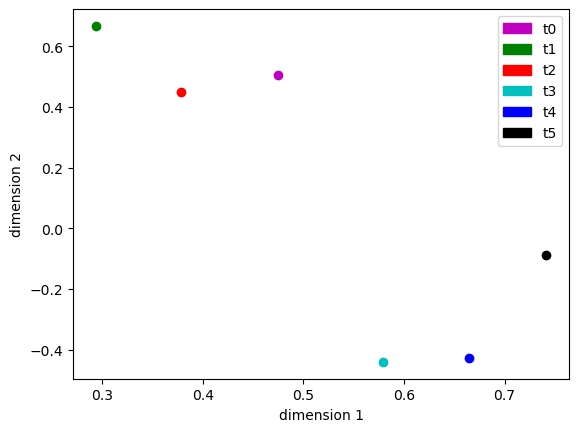

In [23]:
# Implementación de SVD para visualización

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=2);
P=svd.fit_transform(Tfidf_encoding)

#grafico
color = ['m', 'g', 'r', 'c', 'b','k']
plt.figure()
patches = []

for i,texto in enumerate(textos):
    plt.plot(P[i,0], P[i,1], color[i]+"o")
    patches.append(mpatches.Patch(color=color[i], label='t'+str(i)))

plt.legend(handles=patches)
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
#plt.axis([-4, 4, -4, 4])
plt.show()

Como dijimos, las dimensiones que generamos son combinaciones lineales de los términos. Podemos ver cuánto pesa cada término en la definición de estas dimensiones. Ordenemos los términos en función de cuánto pesan en cada dimensión:

In [24]:
comp1,comp2=svd.components_ # coeficientes (pesos) de los términos en cada una de las dos dimensiones

indices=np.argsort(comp1); # los ordenamos de menor a mayor y nos quedamos con los índices de sus posiciones en el array
indices=indices[::-1] # invertimos para que queden ordenados de mayor a menor

print('Dimension 1:')
print(np.array(vectorizer.get_feature_names())[indices]) # Evaluamos los términos en estas posiciones

print('\n')

indices=np.argsort(comp2);
indices=indices[::-1]
print('Dimension 2:')
print(np.array(vectorizer.get_feature_names())[indices])




Dimension 1:
['potro' 'juan' 'martin' 'cine' 'tandil' 'encanto' 'ver' 'recibido'
 'multitud' 'angel' 'casualidad' 'llegaron' 'nacional' 'masas' 'dio'
 'volvio' 'suyos' 'ultimo' 'bano' 'millonaria' 'final' 'cinta' 'unica'
 'mes' 'cerca' 'oscar' 'paso' 'tanque']


Dimension 2:
['angel' 'cine' 'nacional' 'tanque' 'paso' 'oscar' 'cerca' 'llegaron'
 'casualidad' 'millonaria' 'cinta' 'final' 'mes' 'unica' 'potro' 'ver'
 'encanto' 'masas' 'dio' 'suyos' 'ultimo' 'volvio' 'bano' 'multitud'
 'recibido' 'martin' 'juan' 'tandil']


En la representación 2D de los textos se ve que hay dos grupos separados: uno que habla escencialmente de cine y otro que habla de tenis. En un escenario de aprendizaje no supervisado, podríamos encontrar estos grupos mediante un algoritmo de clustering.

<a id="section_babel"></a>

##### Antes de terminar, la cantidad de libros diferentes en la Biblioteca de Babel es: 

[Volver al índice](#section_TOC)

In [25]:
babel=25**(410*40*80);

(el print puede tardar y exigir un poquito a la máquina)

In [28]:
# print(babel)